<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/Bayesian-single-perceptron-TS/Informative_Prior_Bayes_NAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian single-perceptron NAR(d) with recency-decaying prior means

In [1]:
# ===============================
# Bayesian single-perceptron NAR(d)
# with recency-decaying prior means
# ===============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 150  # Set dpi to 200 for high resolution

#plt.rcParams["figure.dpi"] = 150        # higher resolution on screen
#plt.rcParams["savefig.dpi"] = 300       # high-res for saved figures

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate Simulated Nonlinear bounded Time Series

Text(0.5, 1.0, 'Bounded [-1,1] Time Series')

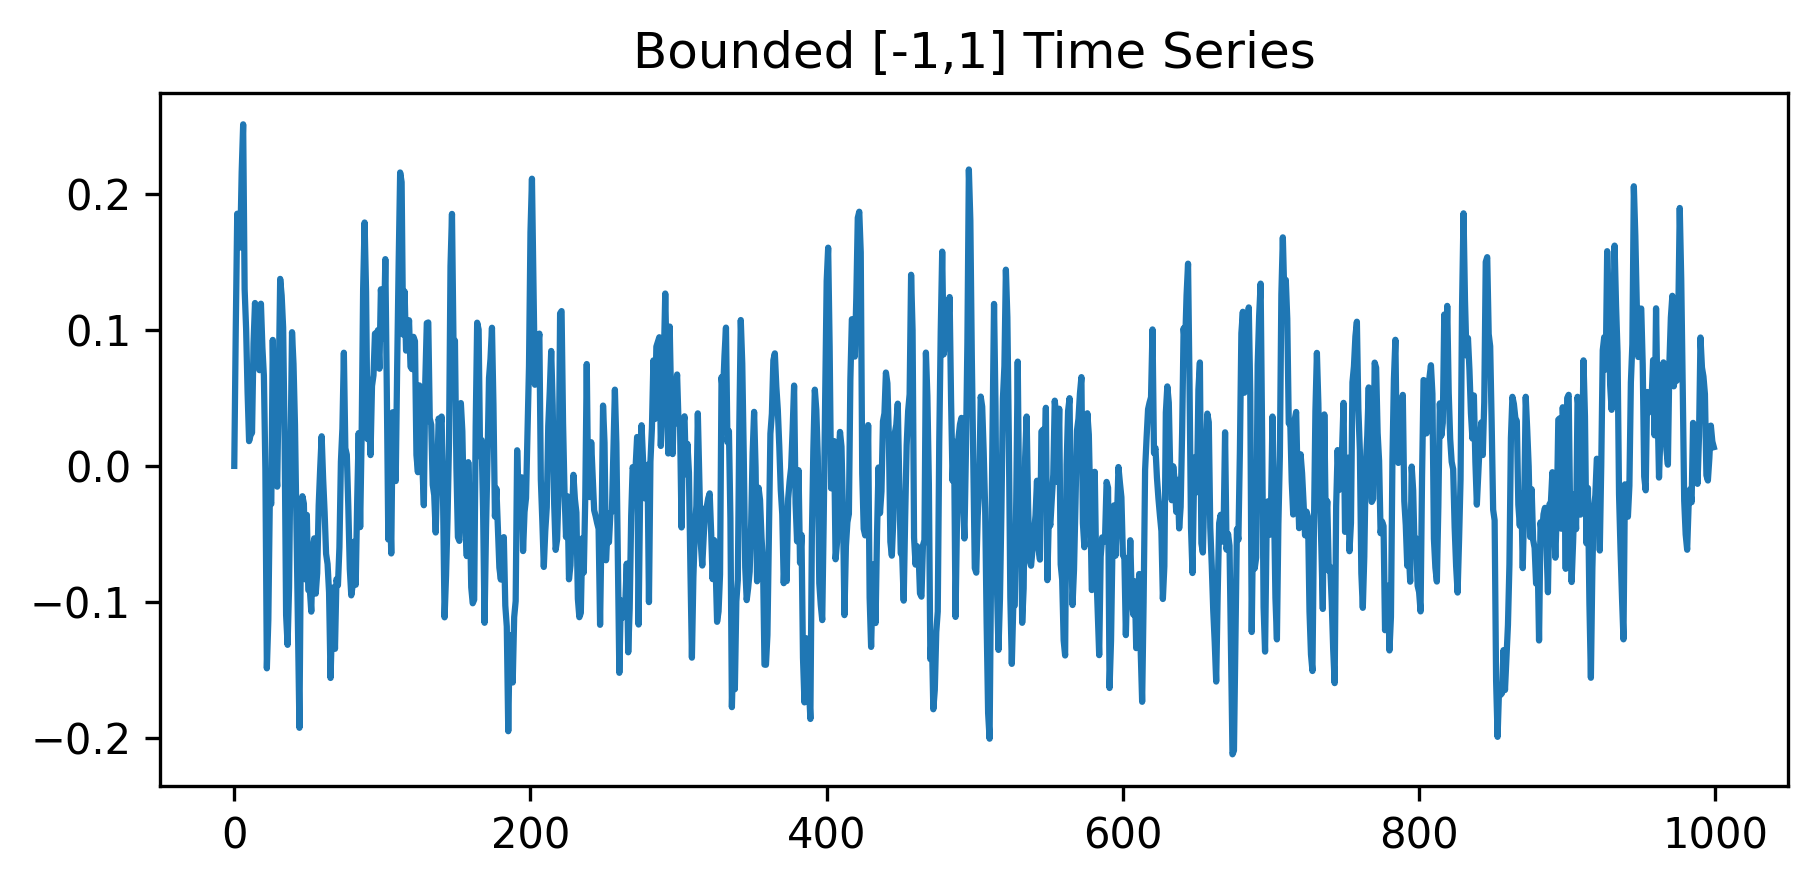

In [2]:
# -----------------------------
# 1) Simulate bounded time series
# -----------------------------
T = 1000
x = np.zeros(T)
x[0], x[1] = 0.0, 0.1
for t in range(2, T):
    x[t] = 0.7 * x[t-1] - 0.3 * x[t-2] + 0.1 * np.sin(3 * x[t-1]) + 0.05 * np.random.randn()
    x[t] = np.tanh(x[t])  # keep within [-1, 1]

# plot this time series
plt.figure(figsize=(7,3))
plt.plot(x)
plt.title("Bounded [-1,1] Time Series")

# Create lagged time series dataframe and tensor

In [3]:
# ---------------------------------
# 2) Build lagged features X_{t-1:t-d}
# ---------------------------------
def make_lagged(series, d):
    N = len(series) - d
    X = np.zeros((N, d), dtype=np.float32)
    y = np.zeros(N, dtype=np.float32)
    for i in range(N):
        # most recent first: [x_{t-1}, x_{t-2}, ..., x_{t-d}]
        X[i] = series[i:i+d][::-1]
        y[i] = series[i+d]
    return X, y

d = 4
X, y = make_lagged(x, d)
N = len(y)

# Train/val/test split by time
n_train = int(0.7*N)
n_val   = int(0.15*N)
idx_tr  = slice(0, n_train)
idx_va  = slice(n_train, n_train+n_val)
idx_te  = slice(n_train+n_val, N)

Xtr, ytr = X[idx_tr], y[idx_tr]
Xva, yva = X[idx_va], y[idx_va]
Xte, yte = X[idx_te], y[idx_te]

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.float32, device=device).unsqueeze(1)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
yva_t = torch.tensor(yva, dtype=torch.float32, device=device).unsqueeze(1)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte, dtype=torch.float32, device=device).unsqueeze(1)

# print shape and Xtr_t
print("Xtr_t shape:", Xtr_t.shape)
print(Xtr_t[:2])
print("ytr_t shape:", ytr_t.shape)
print(ytr_t[:2])
print("Xtr_t dtype:", Xtr_t.dtype)
print("Xtr_t device:", Xtr_t.device)

# form Xtr, ytr into a dataframe
df = pd.DataFrame(Xtr, columns=[f"x_{i}" for i in range(1, d+1)])
df["y"] = ytr
df.head()

Xtr_t shape: torch.Size([697, 4])
tensor([[0.1711, 0.1856, 0.1000, 0.0000],
        [0.1607, 0.1711, 0.1856, 0.1000]])
ytr_t shape: torch.Size([697, 1])
tensor([[0.1607],
        [0.2161]])
Xtr_t dtype: torch.float32
Xtr_t device: cpu


,x_1,x_2,x_3,x_4,y
0,0.171057,0.185579,0.100000,0.000000,0.160692
1,0.160692,0.171057,0.185579,0.100000,0.216112
2,0.216112,0.160692,0.171057,0.185579,0.251333
3,0.251333,0.216112,0.160692,0.171057,0.129952
4,0.129952,0.251333,0.216112,0.160692,0.100734


# Bayes linear layer with per-weight Normal prior: N(mu_p, sigma_p^2)

In [4]:
# ---------------------------------------------------------
# 3) Variational Bayes building block: Bayes linear layer
#    with per-weight Normal prior: N(mu_p, sigma_p^2)
# ---------------------------------------------------------
class BayesLinearWithPriorMean(nn.Module):
    """
    Factorized Normal posterior q(theta)=N(mu, softplus(rho)^2)
    Prior p(theta)=N(mu_p, sigma_p^2) with per-parameter mu_p/sigma_p.
    """
    def __init__(self, in_features, out_features, prior_mu=0.0, prior_sigma=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters
        self.w_mu  = nn.Parameter(torch.zeros(out_features, in_features))
        self.w_rho = nn.Parameter(torch.full((out_features, in_features), -3.0))
        self.b_mu  = nn.Parameter(torch.zeros(out_features))
        self.b_rho = nn.Parameter(torch.full((out_features,), -3.0))

        # Priors as buffers (broadcastable to parameter shapes)
        self.register_buffer("prior_w_mu",
            torch.as_tensor(prior_mu, dtype=torch.float32).expand(out_features, in_features))
        self.register_buffer("prior_w_sig",
            torch.as_tensor(prior_sigma, dtype=torch.float32).expand(out_features, in_features))

        # Bias prior (often 0-mean is a safe default)
        self.register_buffer("prior_b_mu",  torch.zeros(out_features))
        self.register_buffer("prior_b_sig", torch.ones(out_features))

    @staticmethod
    def _kl_normal_q_p(mu_q, sig_q, mu_p, sig_p):
        var_q = sig_q**2
        var_p = sig_p**2
        return 0.5 * ( (var_q + (mu_q - mu_p)**2)/var_p - 1.0 - torch.log(var_q/var_p) )

    def sample_weights(self):
        w_sig = F.softplus(self.w_rho)
        b_sig = F.softplus(self.b_rho)
        W = self.w_mu + w_sig * torch.randn_like(self.w_mu)
        b = self.b_mu + b_sig * torch.randn_like(self.b_mu)
        return W, b, w_sig, b_sig

    def kl_divergence(self, w_sig, b_sig):
        kl_w = self._kl_normal_q_p(self.w_mu, w_sig, self.prior_w_mu, self.prior_w_sig).sum()
        kl_b = self._kl_normal_q_p(self.b_mu, b_sig, self.prior_b_mu, self.prior_b_sig).sum()
        return kl_w + kl_b

    def forward(self, x, sample=True):
        if sample:
            W, b, w_sig, b_sig = self.sample_weights()
            out = x @ W.t() + b
            kl  = self.kl_divergence(w_sig, b_sig)
            return out, kl
        else:
            out = x @ self.w_mu.t() + self.b_mu
            kl = torch.tensor(0.0, device=x.device)
            return out, kl

# ----------------------------------------------------
# 4) Bayesian single perceptron: tanh(w^T x + b)
# ----------------------------------------------------
class BayesianSinglePerceptron(nn.Module):
    def __init__(self, d, prior_mu_vec=None, prior_sigma_vec=None):
        super().__init__()
        if prior_mu_vec is None:
            prior_mu_vec = torch.zeros(d)
        if prior_sigma_vec is None:
            prior_sigma_vec = torch.full((d,), 0.5)

        prior_mu = prior_mu_vec.unsqueeze(0)     # shape [1, d]
        prior_sd = prior_sigma_vec.unsqueeze(0)  # shape [1, d]

        self.blin = BayesLinearWithPriorMean(d, 1, prior_mu=prior_mu, prior_sigma=prior_sd)
        # observation noise (not strictly needed with tanh-bounded y; keeps ELBO well-behaved)
        self.log_sigma_eps = nn.Parameter(torch.tensor(-2.0))

    def forward(self, x, sample=True):
        lin, kl = self.blin(x, sample=sample)
        yhat = torch.tanh(lin)  # keep output in [-1,1]
        sigma_eps = F.softplus(self.log_sigma_eps) + 1e-6
        return yhat, sigma_eps, kl

# Recency-decaying prior mean constructor

In [5]:
# -----------------------------------------
# 5) Recency-decaying prior mean constructor
# -----------------------------------------
def make_recency_prior_means(d, c=0.25, lam=0.35, sign=None):
    """
    m_k = c * exp(-lam*(k-1)) * sign_k, with k=1 most recent.
    sign: None → all positive; or a tensor/list of length d in {-1, +1}.
    """
    k = torch.arange(1, d+1, dtype=torch.float32)
    base = c * torch.exp(-lam*(k-1))
    if sign is None:
        return base
    s = torch.as_tensor(sign, dtype=torch.float32)
    return base * s

# Visualize what the recency-decaying prior mean function looks like

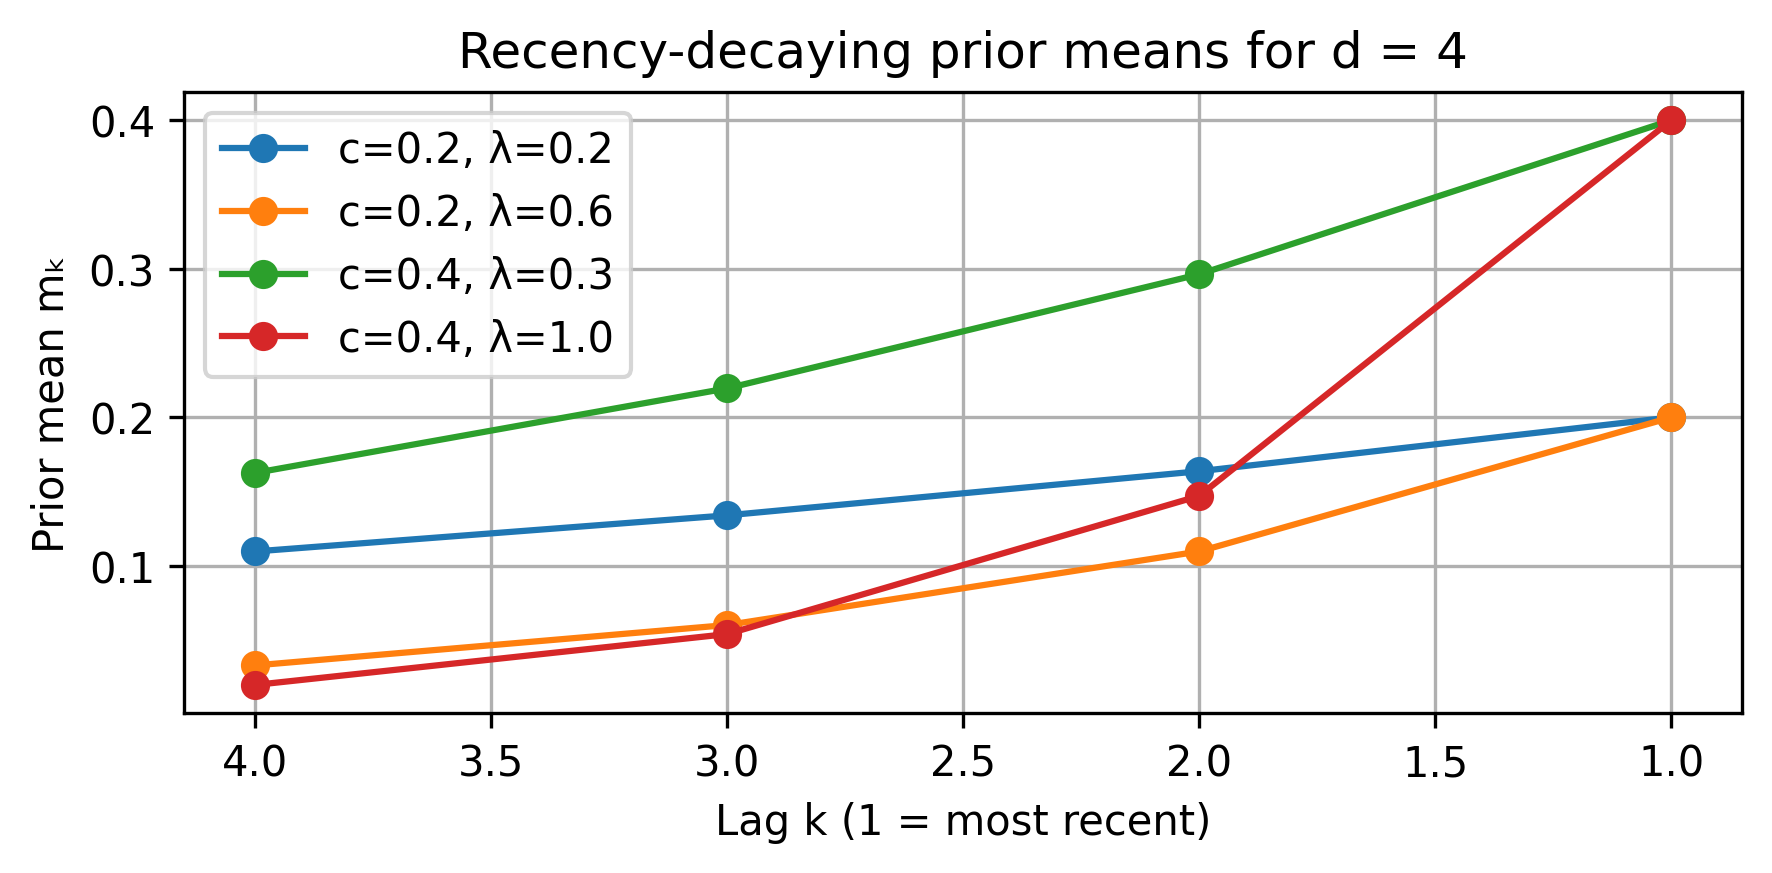

In [6]:
# --- Plot the function for d = 4 ---
d = 4
configs = [
    {"c": 0.2, "lam": 0.2},
    {"c": 0.2, "lam": 0.6},
    {"c": 0.4, "lam": 0.3},
    {"c": 0.4, "lam": 1.0},
]

plt.figure(figsize=(6, 3))
for cfg in configs:
    m = make_recency_prior_means(d, c=cfg["c"], lam=cfg["lam"])
    plt.plot(range(1, d+1), m.numpy(), "o-", label=f"c={cfg['c']}, λ={cfg['lam']}")

plt.gca().invert_xaxis()  # lag 1 (most recent) on the left
plt.xlabel("Lag k (1 = most recent)")
plt.ylabel("Prior mean mₖ")
plt.title("Recency-decaying prior means for d = 4")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ELBO step with MC samples + beta anneal and Train function

In [7]:
# -----------------------------------------
# 6) ELBO step with MC samples + beta anneal
# -----------------------------------------
def elbo_step(model, x, y, num_samples=3, beta=1.0):
    total_nll = 0.0
    total_kl  = 0.0
    for _ in range(num_samples):
        yhat, sigma_eps, kl = model(x, sample=True)
        # Gaussian NLL up to constant
        nll = 0.5 * (((y - yhat) ** 2) / (sigma_eps**2) + 2.0 * torch.log(sigma_eps)).sum()
        total_nll += nll
        total_kl  += kl
    nll = total_nll / num_samples
    kl  = total_kl  / num_samples
    loss = nll + beta * kl
    mse_like = ((y - yhat) ** 2).mean().detach()
    return loss, nll.detach(), kl.detach(), mse_like

# -----------------------------------------
# 7) Training loop (with β-annealing)
# -----------------------------------------
def train_model(model, Xtr, ytr, Xva, yva, epochs=600, lr=5e-3, weight_decay=0.0,
                mc=3, beta_start=0.05, beta_end=1.0, beta_warmup=200, verbose=True):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    hist = {"train_mse": [], "val_mse": [], "beta": []}
    for ep in range(1, epochs+1):
        # cosine/linear or simple linear anneal
        beta = beta_end if ep >= beta_warmup else beta_start + (beta_end-beta_start)*ep/beta_warmup
        model.train()
        opt.zero_grad()
        loss, nll, kl, mse = elbo_step(model, Xtr, ytr, num_samples=mc, beta=beta)
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            yhat_va, _, _ = model(Xva, sample=False)  # deterministic (posterior means)
            val_mse = ((yva - yhat_va)**2).mean().item()

        hist["train_mse"].append(mse.item())
        hist["val_mse"].append(val_mse)
        hist["beta"].append(beta)

        if verbose and ep % 100 == 0:
            print(f"Epoch {ep:4d} | beta={beta:0.3f} | train MSE={mse.item():.4f} | val MSE={val_mse:.4f}")
    return hist

# Build models: zero-mean vs recency-mean priors and Train

In [8]:
# -----------------------------------------
# 8) Build models: zero-mean vs recency-mean priors
# -----------------------------------------
# Prior std across lags (can be constant first)
prior_sigma_vec = torch.full((d,), 0.5)

# A) Zero-mean prior (baseline)
model_zero = BayesianSinglePerceptron(d, prior_mu_vec=torch.zeros(d), prior_sigma_vec=prior_sigma_vec)

# B) Recency-decaying mean prior
prior_mu_vec = make_recency_prior_means(d, c=0.25, lam=0.35, sign=None)
print("Recency-decaying prior means:", prior_mu_vec.numpy().round(4))
model_rec = BayesianSinglePerceptron(d, prior_mu_vec=prior_mu_vec, prior_sigma_vec=prior_sigma_vec)

# Train both
print("\n-- Training ZERO-MEAN prior model --")
hist_zero = train_model(model_zero, Xtr_t, ytr_t, Xva_t, yva_t,
                        epochs=600, lr=5e-3, mc=3, beta_warmup=200, verbose=True)

print("\n-- Training RECENCY-MEAN prior model --")
hist_rec  = train_model(model_rec, Xtr_t, ytr_t, Xva_t, yva_t,
                        epochs=600, lr=5e-3, mc=3, beta_warmup=200, verbose=True)

Recency-decaying prior means: [0.25   0.1762 0.1241 0.0875]

-- Training ZERO-MEAN prior model --
Epoch  100 | beta=0.525 | train MSE=0.0041 | val MSE=0.0026
Epoch  200 | beta=1.000 | train MSE=0.0029 | val MSE=0.0022
Epoch  300 | beta=1.000 | train MSE=0.0025 | val MSE=0.0022
Epoch  400 | beta=1.000 | train MSE=0.0026 | val MSE=0.0021
Epoch  500 | beta=1.000 | train MSE=0.0027 | val MSE=0.0022
Epoch  600 | beta=1.000 | train MSE=0.0025 | val MSE=0.0021

-- Training RECENCY-MEAN prior model --
Epoch  100 | beta=0.525 | train MSE=0.0045 | val MSE=0.0026
Epoch  200 | beta=1.000 | train MSE=0.0028 | val MSE=0.0022
Epoch  300 | beta=1.000 | train MSE=0.0026 | val MSE=0.0021
Epoch  400 | beta=1.000 | train MSE=0.0026 | val MSE=0.0021
Epoch  500 | beta=1.000 | train MSE=0.0027 | val MSE=0.0021
Epoch  600 | beta=1.000 | train MSE=0.0027 | val MSE=0.0021


# Plot the Monte Carlo Predictive Uncertainty for each model

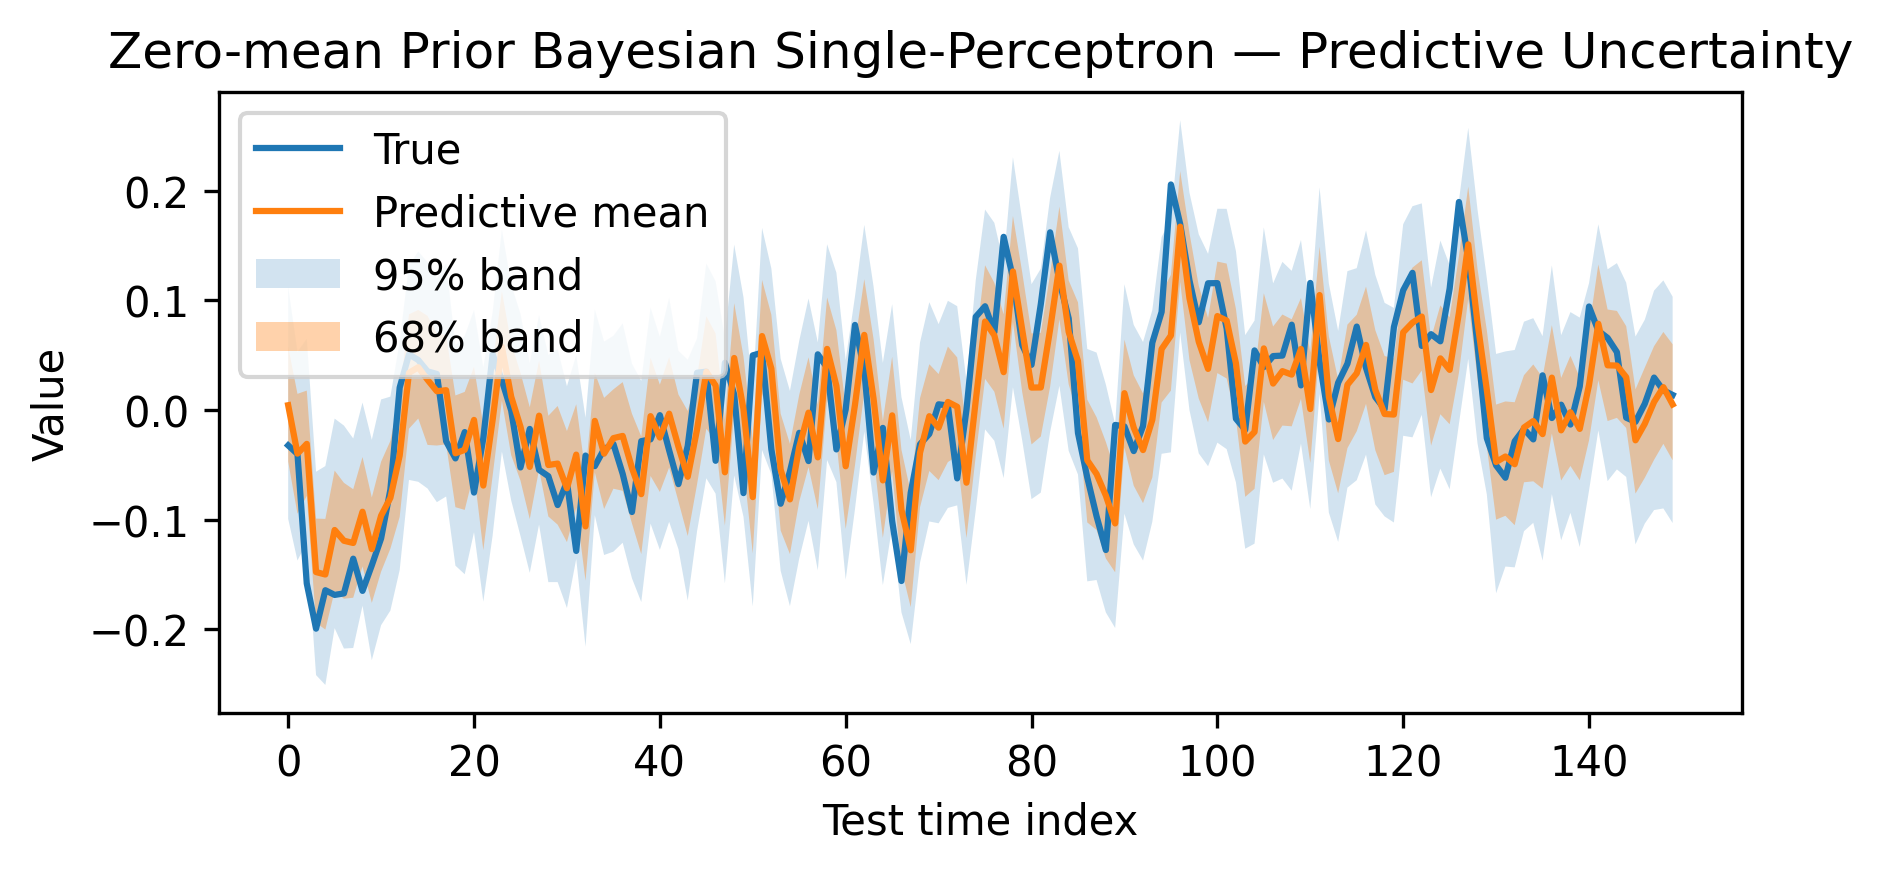

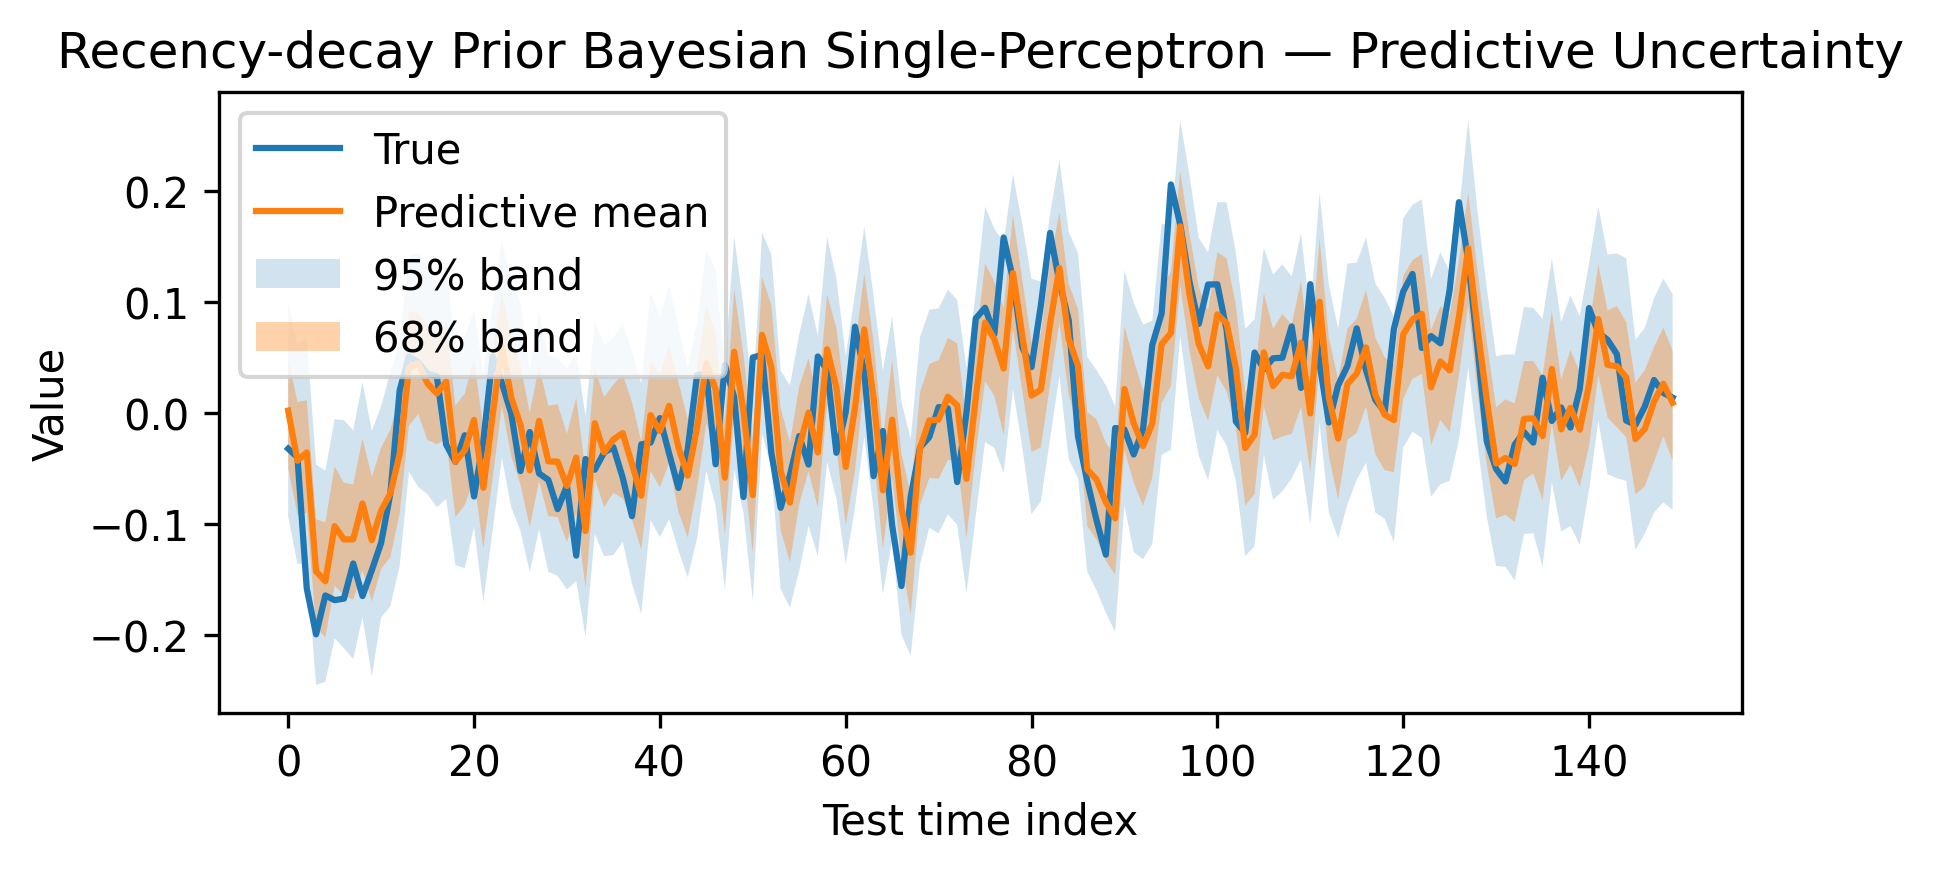

Test MSE — zero-mean prior:   0.0024
Test MSE — recency-decay prior:0.0023


In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- MC predictive sampler (posterior over weights + optional observation noise) ---
@torch.no_grad()
def predict_mc(model, X, n_samples=300, include_obs_noise=True):
    model.eval()
    preds = []
    for _ in range(n_samples):
        # sample weights/biases via model(..., sample=True)
        yhat, sigma_eps, _ = model(X, sample=True)  # [N,1]
        if include_obs_noise:
            yhat = yhat + sigma_eps * torch.randn_like(yhat)
        preds.append(yhat.squeeze(1).cpu().numpy())
    P = np.stack(preds, axis=0)  # [S, N]
    mean = P.mean(axis=0)
    lo95, hi95 = np.percentile(P, [2.5, 97.5], axis=0)
    lo68, hi68 = np.percentile(P, [16.0, 84.0], axis=0)
    return mean, (lo68, hi68), (lo95, hi95)

# --- Run MC predictions for both models on test set ---
mean_zero, (lo68_z, hi68_z), (lo95_z, hi95_z) = predict_mc(model_zero, Xte_t, n_samples=400, include_obs_noise=True)
mean_rec,  (lo68_r, hi68_r), (lo95_r, hi95_r) = predict_mc(model_rec,  Xte_t, n_samples=400, include_obs_noise=True)

y_true = yte_t.squeeze(1).cpu().numpy()

# --- Plot: ZERO-MEAN prior model ---
plt.figure(figsize=(6,3))
plt.plot(y_true, label="True")
plt.plot(mean_zero, label="Predictive mean")
plt.fill_between(np.arange(len(y_true)), lo95_z, hi95_z, alpha=0.2, label="95% band")
plt.fill_between(np.arange(len(y_true)), lo68_z, hi68_z, alpha=0.35, label="68% band")
plt.title("Zero-mean Prior Bayesian Single-Perceptron — Predictive Uncertainty")
plt.xlabel("Test time index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot: RECENCY-DECAY prior model ---
plt.figure(figsize=(6,3))
plt.plot(y_true, label="True")
plt.plot(mean_rec, label="Predictive mean")
plt.fill_between(np.arange(len(y_true)), lo95_r, hi95_r, alpha=0.2, label="95% band")
plt.fill_between(np.arange(len(y_true)), lo68_r, hi68_r, alpha=0.35, label="68% band")
plt.title("Recency-decay Prior Bayesian Single-Perceptron — Predictive Uncertainty")
plt.xlabel("Test time index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) quick numeric comparison
mse_zero = np.mean((mean_zero - y_true)**2)
mse_rec  = np.mean((mean_rec  - y_true)**2)
print(f"Test MSE — zero-mean prior:   {mse_zero:.4f}")
print(f"Test MSE — recency-decay prior:{mse_rec:.4f}")

# Evaluate on test set & plot predictions


Test MSE  (zero-mean prior):   0.0023
Test MSE  (recency-mean prior): 0.0024


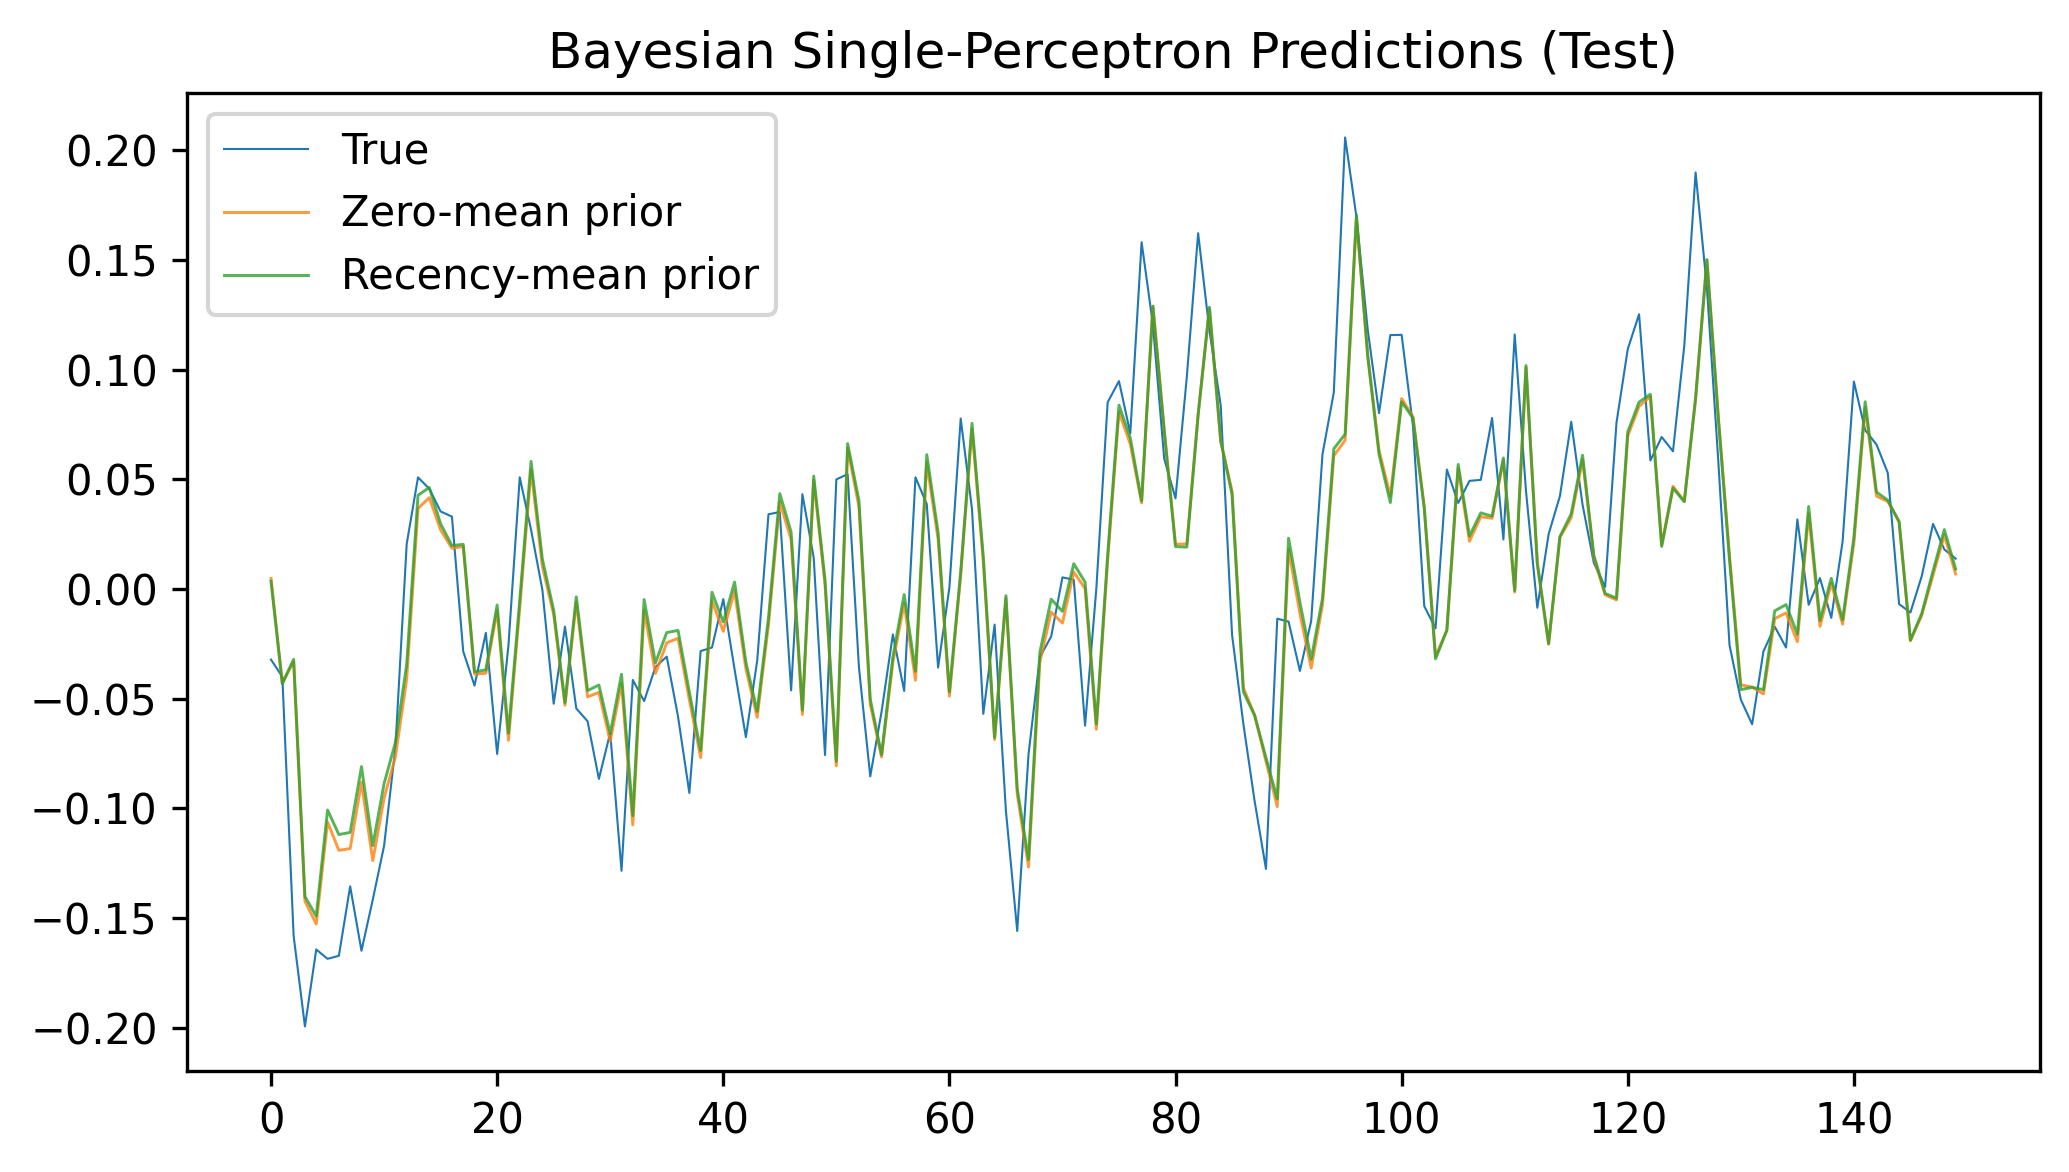

In [10]:
# -----------------------------------------
# 9) Evaluate on test set & plot predictions
# -----------------------------------------
def predict_point_estimate(model, X):
    model.eval()
    with torch.no_grad():
        yhat, _, _ = model(X, sample=False)  # posterior means
        return yhat.squeeze().cpu().numpy()

yhat_zero = predict_point_estimate(model_zero, Xte_t)
yhat_rec  = predict_point_estimate(model_rec,  Xte_t)

test_mse_zero = np.mean((yhat_zero - yte)**2)
test_mse_rec  = np.mean((yhat_rec  - yte)**2)
print(f"\nTest MSE  (zero-mean prior):   {test_mse_zero:.4f}")
print(f"Test MSE  (recency-mean prior): {test_mse_rec:.4f}")

plt.figure(figsize=(7,4))
plt.plot(yte, label="True", linewidth=0.5)
plt.plot(yhat_zero, label="Zero-mean prior", alpha=0.8, linewidth = 0.7)
plt.plot(yhat_rec, label="Recency-mean prior", alpha=0.8, linewidth = 0.7)
plt.title("Bayesian Single-Perceptron Predictions (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# visualize posterior mean weights

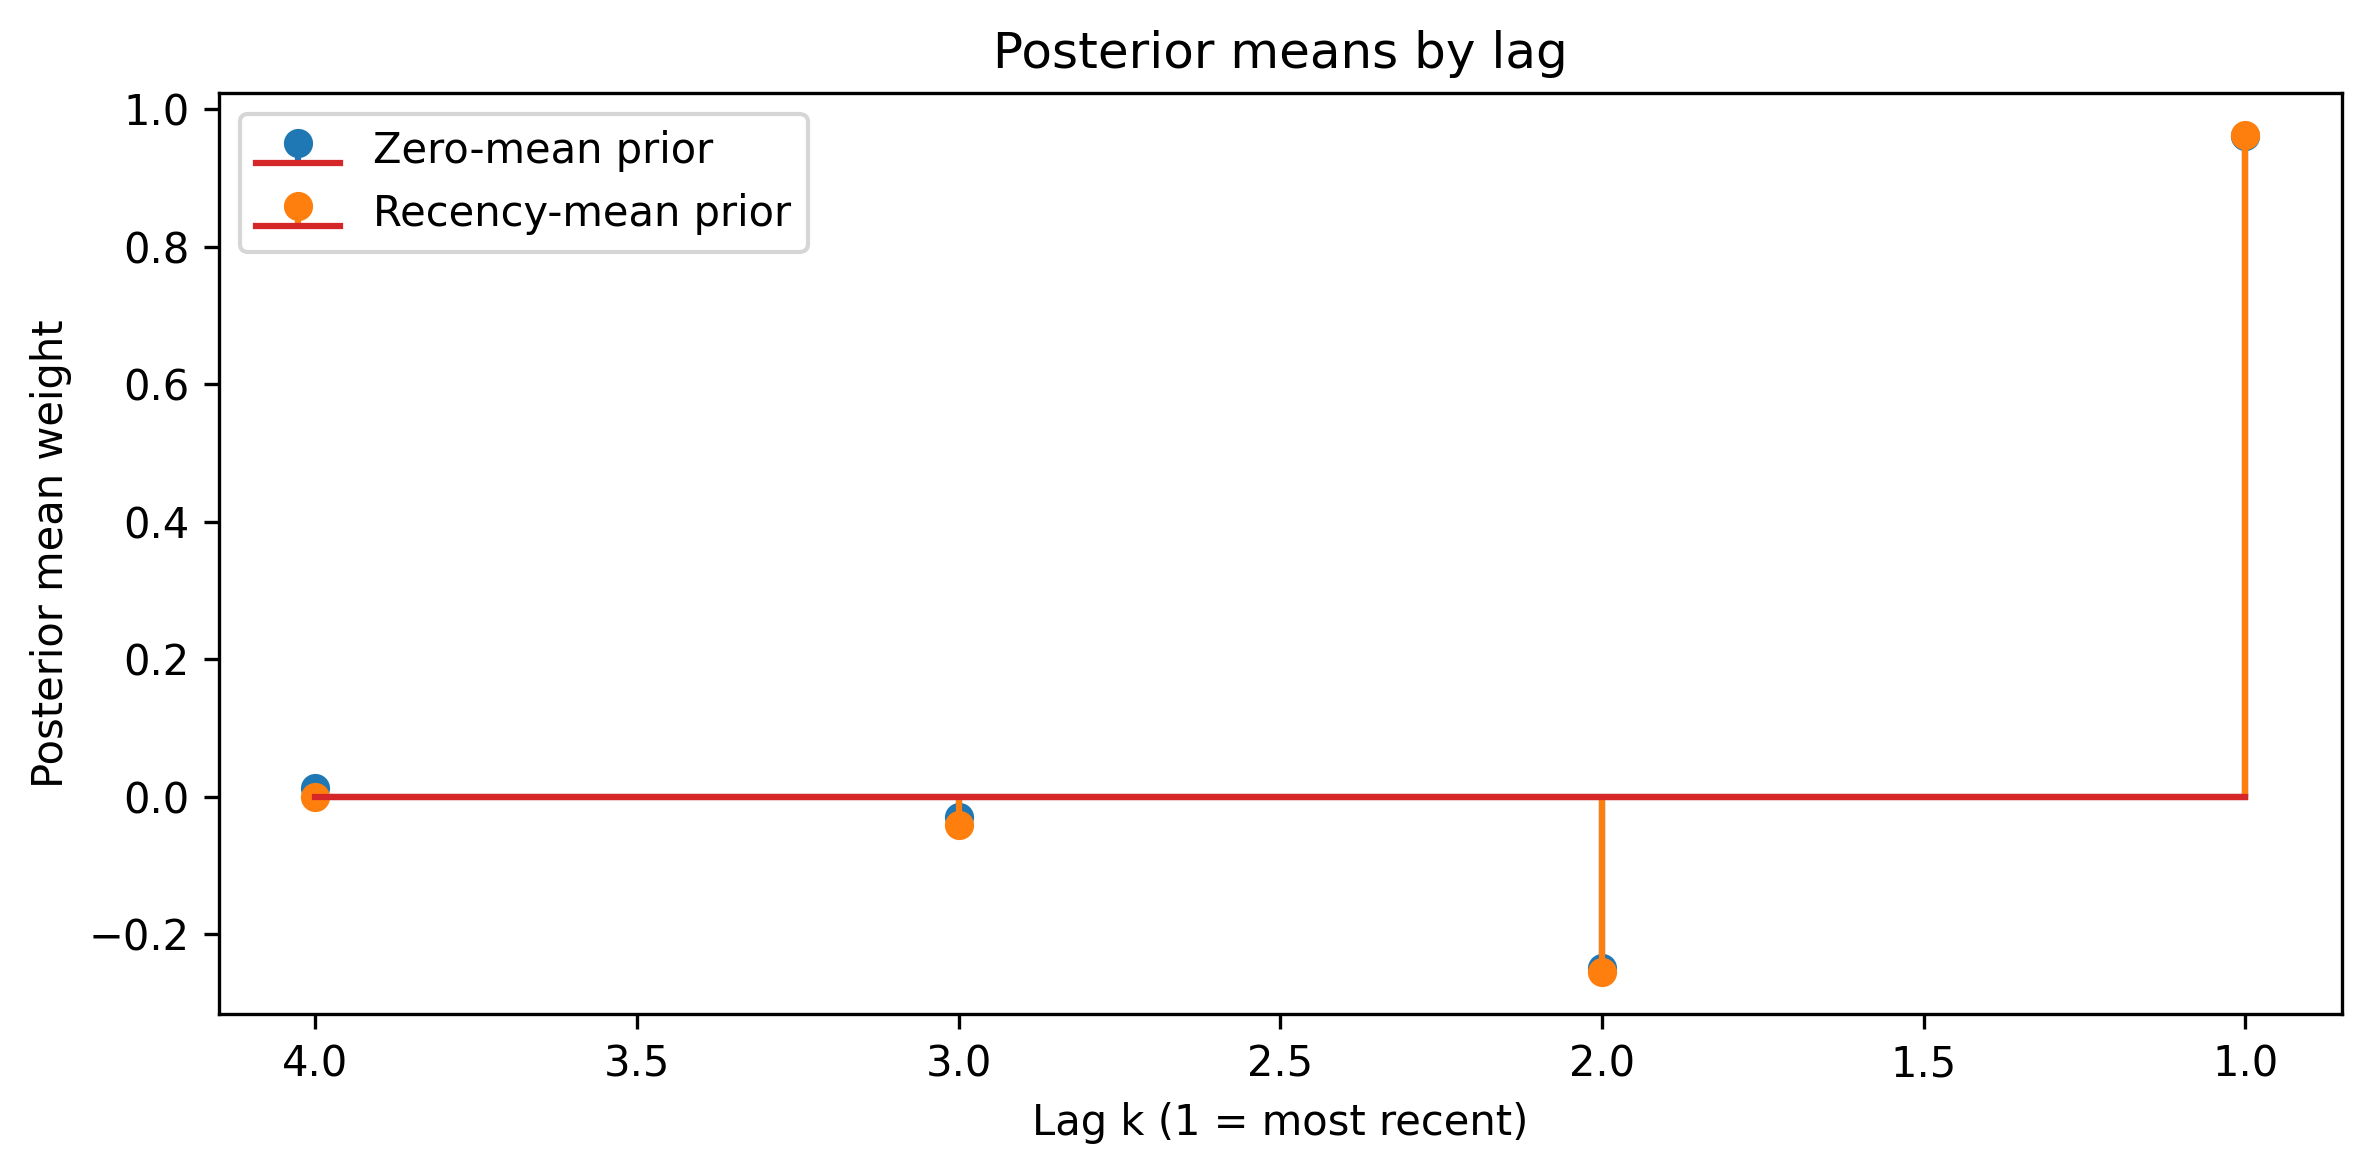

In [11]:
# Optional: visualize posterior mean weights
def get_weight_means(model):
    return model.blin.w_mu.detach().cpu().squeeze().numpy()

w_zero = get_weight_means(model_zero)
w_rec  = get_weight_means(model_rec)

plt.figure(figsize=(8,4))
plt.stem(np.arange(1,d+1), w_zero, label="Zero-mean prior")
plt.stem(np.arange(1,d+1), w_rec, label="Recency-mean prior", markerfmt='C1o', linefmt='C1-')
plt.gca().invert_xaxis()  # show lag-1 at left visually "closest"
plt.xlabel("Lag k (1 = most recent)")
plt.ylabel("Posterior mean weight")
plt.title("Posterior means by lag")
plt.legend()
plt.tight_layout()
plt.show()